## Trabalho de Princípios de Sistemas de Comunicação
Este notebook tem como objetivo implementar, em python, o exercício 6 do capítulo 2 da disciplina de Princípios de Sistemas de Comunicação.

O objetivo é utilizar técnicas de modulação em aplitude para implmentar um sistema que embaralha um sinal de áudio e também recupera um sinal de áudio embaralhado, conforme o enunciado em anexo nessa pasta [enunciado.png].

Para melhor organização, as funções de embaralhamento e plotagem do espectro foram desenvolvidas em um arquivo separado [utils.py]. O código está comentado passo a passo e explica o funcionamento do sistema.

Nessa pasta, há o áudio original [voz_equalizada.wav], o qual foi equalizado com a atenuação das frequências mais altas, por recomendação do professor. Além disso, o arquivo [audio_embaralhado.wav] contém o áudio que passou pelo sistema pela primeira vez. Por último, como resultado final, o arquivo [audio_desembaralhado.wav] contém a saída do sistema para a entrada do áudio embaralhado.

In [47]:
#importando as bilbiotecas
import numpy as np
from scipy.io import wavfile
from scipy.signal import resample, butter, sosfilt
import matplotlib.pyplot as plt
from utils import embaralhamento, plot_espectro
from scipy.io.wavfile import write
from IPython.display import Audio

In [48]:
#lendo e convertendo para numpy
input_wav_file = 'voz_equalizada.wav'
try:
    fs_orig, audio_orig = wavfile.read(input_wav_file)
except FileNotFoundError:
    print(f"ERRO: Arquivo '{input_wav_file}' não encontrado.")
    exit()

In [49]:
#pré processamento:
#transformando para mono:
audio_orig = audio_orig[:, 0] 
#normalizando:
audio_orig = audio_orig / np.max(np.abs(audio_orig))
#reamostrando para poder trabalhar em frequências mais altas, evitando o aliasing:
fs_new = 96000
audio_resampled = resample(audio_orig, int(len(audio_orig) * fs_new / fs_orig))

Espectro do audio original:

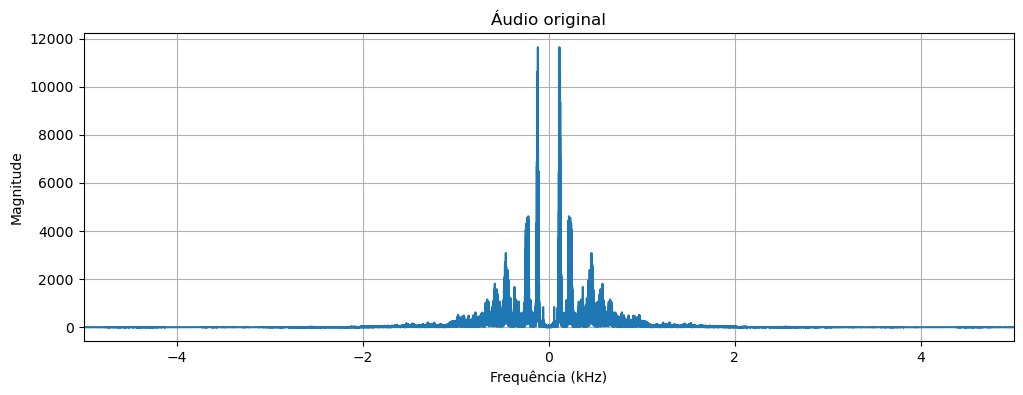

In [50]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_espectro(audio_resampled, fs_new, 'Áudio original', ax)
ax.set_xlim(-5, 5)  # Limita o eixo x de -30 kHz a 30 kHz
plt.show()

Com o áudio carregado e pré-processado, podemos passá-lo pelo sistema:

In [51]:
audio_embaralhado, x1, x2, x3 = embaralhamento(audio_resampled, fs_new)

Espectros dos sinais interediários:
- O primeiro é do sinal após a primeira modulação. Nota-se que o espectro foi descolado para a frequência da portadora, caracterizando a modulação DSB-SC;
- O segundo é o sinal anterior filtrado por um filtro passa altas butteworth de 8a ordem, com frequência de corte igual à frequência da portadora;
- O terceiro é o sinal modulado novamente, agora a portadora é de 25 kHz;
- Por fim, temos o espectro do sinal embaralhado, após a filtragem passa baixas de oitava ordem, com frequência de corte de 20kHz.



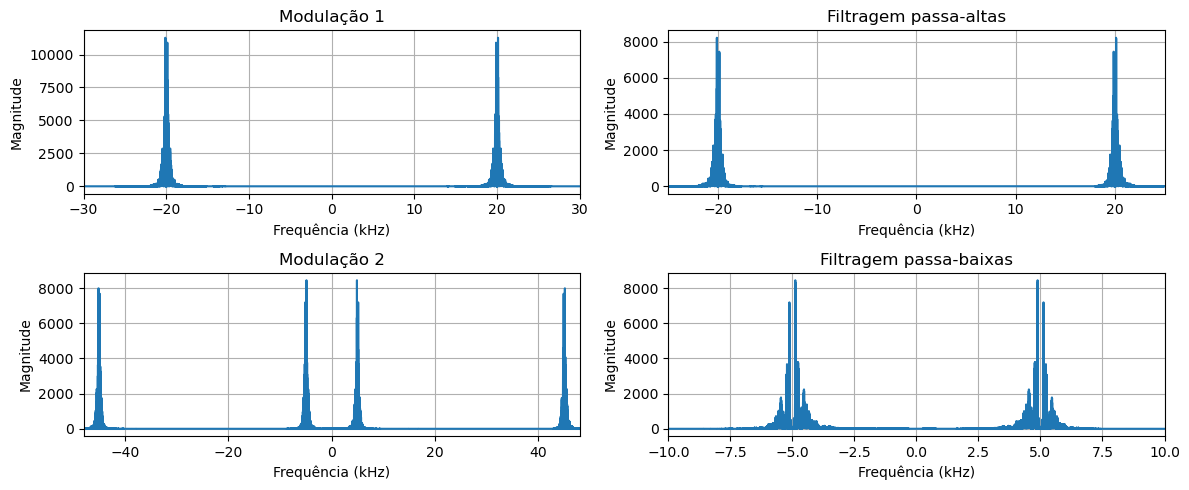

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(12, 5))
plot_espectro(x1, fs_new, 'Modulação 1', axs[0,0])
axs[0,0].set_xlim(-30, 30)
plot_espectro(x2, fs_new, 'Filtragem passa-altas', axs[0,1])
axs[0,1].set_xlim(-25, 25)
plot_espectro(x3, fs_new, 'Modulação 2', axs[1,0])
plot_espectro(audio_embaralhado, fs_new, 'Filtragem passa-baixas', axs[1,1])
axs[1,1].set_xlim(-10, 10)
plt.tight_layout()
plt.show()

Vamos analisar os resultados:
- Comparação dos espectros do áudio original e do áudio embaralhado;
- Reprodução do áudio embaralhado.

In [53]:
write('audio_embaralhado.wav', fs_new, (audio_embaralhado * 32767).astype('int16'))
Audio(audio_embaralhado, rate=fs_new)

Agora, vamos passar o áudio embaralhado novamente pelo sistema:

In [54]:
audio_desembaralhado, x4, x5, x6 = embaralhamento(audio_embaralhado, fs_new)

Temos, novamente, os sinais intermediários plotados abaixo:

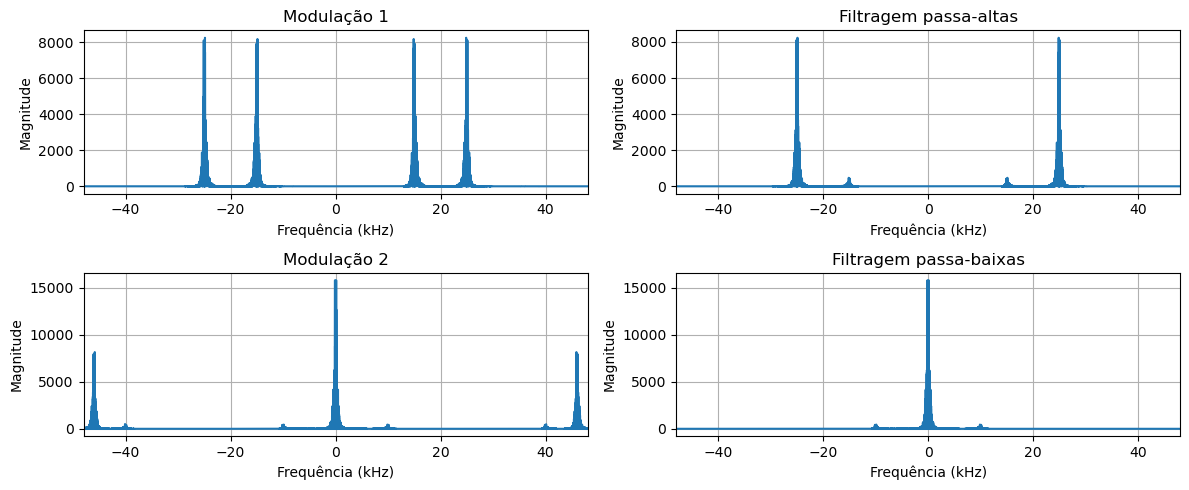

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(12, 5))
plot_espectro(x4, fs_new, 'Modulação 1', axs[0,0])
#axs[0,0].set_xlim(-30, 30)
plot_espectro(x5, fs_new, 'Filtragem passa-altas', axs[0,1])
#axs[0,1].set_xlim(-25, 25)
plot_espectro(x6, fs_new, 'Modulação 2', axs[1,0])
plot_espectro(audio_desembaralhado, fs_new, 'Filtragem passa-baixas', axs[1,1])
#axs[1,1].set_xlim(-10, 10)
plt.tight_layout()
plt.show()

Vizualização do espectro do áudio original x áudio desembaralhado:

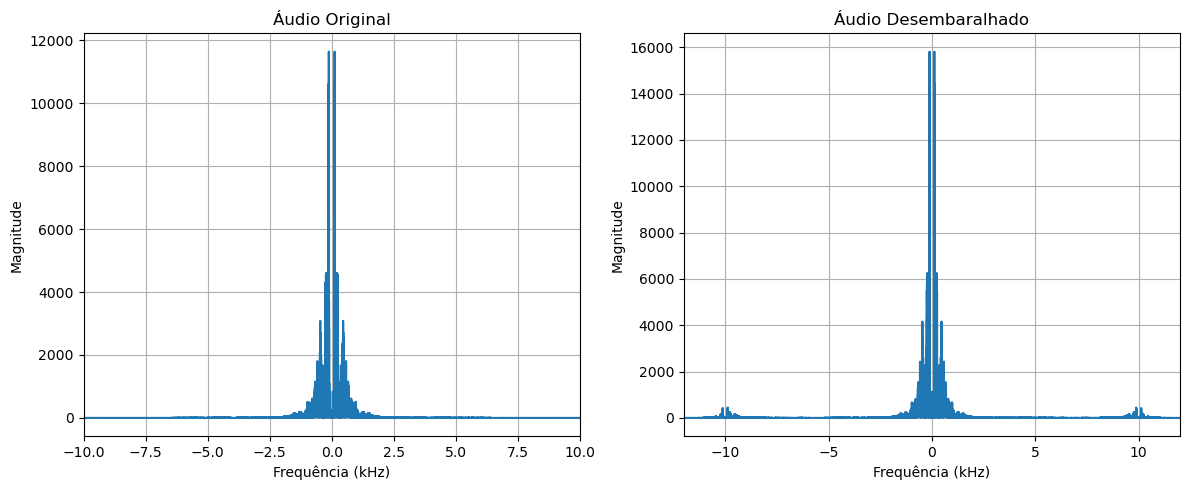

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plot_espectro(audio_resampled, fs_new, 'Áudio Original', axs[0])
axs[0].set_xlim(-10,10)
plot_espectro(audio_desembaralhado, fs_new, 'Áudio Desembaralhado', axs[1])
axs[1].set_xlim(-12,12)
write('audio_desembaralhado.wav', fs_new, (audio_desembaralhado * 32767).astype('int16'))
plt.tight_layout()
plt.show()

Por fim, vamos reproduzir o áudio desembaralhado:

In [57]:
Audio(audio_desembaralhado, rate=fs_new)

Pode-se notar que o áudio desembaralhado possui componentes remanescentes em 10kHz, após a segunda filtragem passa-altas. Portanto, vamos passar o sinal por um filtro passa-baixas:

In [ ]:
#filtragem passa-baixas:
f_corte = 3500
ordem = 8
nyquist = fs_new / 2
normal_cutoff_fpb = f_corte / nyquist
sos_pb = butter(8, normal_cutoff_fpb, btype='low', analog=False, output='sos')
audio_desembaralhado_filtrado = sosfilt(sos_pb, audio_desembaralhado)

Espectro do áudio que foi embaralhado, desembaralhado e por último, filtrado:

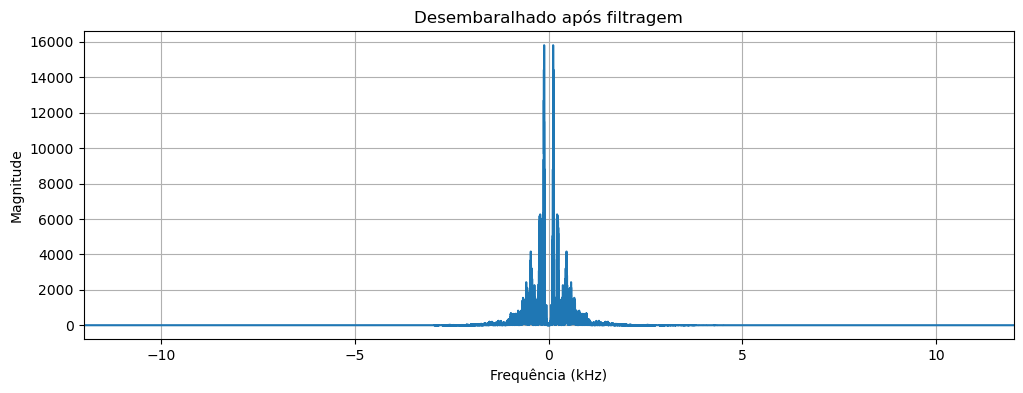

In [60]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_espectro(audio_desembaralhado_filtrado, fs_new, 'Desembaralhado após filtragem', ax)
ax.set_xlim(-12, 12)  # Limita o eixo x de -30 kHz a 30 kHz
plt.show()

Por fim, eis o áudio filtrado. Nota-se uma melhora considerável na percepção auditiva da SNR.

In [61]:
write('audio_desembaralhado_filtrado.wav', fs_new, (audio_desembaralhado_filtrado * 32767).astype('int16'))
Audio(audio_desembaralhado_filtrado, rate=fs_new)